In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import random as rand

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)

# Read Data

## Amazon Fashion From Paper
https://arxiv.org/pdf/1711.02231.pdf

### Full Dataset

In [ ]:
dataset = np.load('Data/AmazonFashion6ImgPartitioned.npy', allow_pickle=True, encoding='latin1')
[user_train, user_validation, user_test, Item, usernum, itemnum] = dataset

### Dataset for SVD

In [43]:
df_user_train = pd.read_pickle('Data/cnn_paper/user_train')
df_user_val = pd.read_pickle('Data/cnn_paper/user_val')
df_user_test = pd.read_pickle('Data/cnn_paper/user_test')

In [44]:
df = pd.concat([df_user_train, df_user_val, df_user_test])

In [45]:
df.head()

,user,item,reviewerName,helpful,reviewText,rating,summary,unixReviewTime,reviewTime,productid
0,A1JWX45KHE34AL,B00APT3MHO,varnienarsil,"[0, 0]",Good for someone who likes skinny jeans but do...,5.0,Love these jeans,1384646400,"11 17, 2013",1
1,A1JWX45KHE34AL,B00CJ5NH36,varnienarsil,"[0, 0]",This shirt with it's bold graphic is seriously...,5.0,As cute as it looks,1384646400,"11 17, 2013",2
2,A1JWX45KHE34AL,B00F9NGAPM,varnienarsil,"[1, 1]",The shirt is a little flowy-er than I expected...,3.0,"Like, don't love",1384646400,"11 17, 2013",4
3,A2YHF6O2D37PMX,B000LYFF46,DCP,"[0, 0]","I selected &#34;fit as expected&#34;, but they...",3.0,Just not comfortable for me,1393804800,"03 3, 2014",5
4,A2YHF6O2D37PMX,B005FPAC8K,DCP,"[3, 3]",May 27: I've worn them 3-4 times each since M...,1.0,Lowered my rating,1336348800,"05 7, 2012",6


## MovieLens

In [81]:
df = pd.read_csv('Data/movie_lens_ratings_small.csv').drop(columns=['timestamp'])
df.head()
df.columns = ['user', 'item', 'rating']
print('rating interval:', df.rating.unique().min(), ',', df.rating.unique().max())
df.head()

rating interval: 0.5 , 5.0


,user,item,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [24]:
df_user_train = pd.DataFrame(columns=list(df))
df_user_val = pd.DataFrame(columns=list(df))
df_user_test = pd.DataFrame(columns=list(df))

users = df['user'].unique()

for u in users:
    df_temp = df[df['user']==u][['user', 'item', 'rating']]
    df_user_train = df_user_train.append(df_temp.iloc[2:])
    df_user_val = df_user_val.append(df_temp.iloc[0])
    df_user_test = df_user_test.append(df_temp.iloc[1])

In [26]:
df_user_train.to_pickle('Data/user_train')
df_user_val.to_pickle('Data/user_val')
df_user_test.to_pickle('Data/user_test')

In [80]:
df_user_train = pd.read_pickle('Data/user_train_ml')
df_user_val = pd.read_pickle('Data/user_val_ml')
df_user_test = pd.read_pickle('Data/user_test_ml')

In [25]:
print(len(df_user_train), len(df_user_test), len(df_user_val))

98662 671 671


## Data stats

In [82]:
norpu = df.groupby('user')['rating'].count().mean()
norpi = df.groupby('item')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

In [83]:
# df = df.sample(frac=0.5, random_state=1234)

rows  100004 
#ratings 100004 
#ratings/user 149.04 
#ratings/item 11.03 
average rating 3.54 
#users  671 
#items  9066


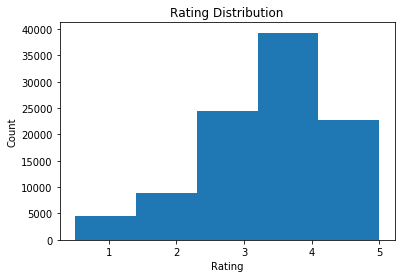

In [84]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\n#ratings/item', round(norpi,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size)
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()

# SVD

## Data Prep

In [85]:
def transform(df):
    items = df['item'].unique()
    itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
    itemsDF['new_item_id'] = itemsDF.index

    users = df['user'].unique()
    usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
    usersDF['new_user_id'] = usersDF.index

    ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
    ratingDF = ratingDF.drop(columns=['original_item_id'])

    ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
    ratingDF = ratingDF.drop(columns=['original_user_id'])

    df_new_ids = ratingDF
    print('Full data #row: ', df_new_ids.shape[0])
    df_new_ids.head()
    
    return df_new_ids

# df_new_ids = transform(df)
train_set = transform(df_user_train)
val_set = transform(df_user_val)
test_set = transform(df_user_test)

Full data #row:  98662
Full data #row:  671
Full data #row:  671


## Model

In [86]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.alpha_cb = params['alpha_cb']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.use_color = params['use_color']
        self.use_weight_ver = params['use_weight_ver']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.cb_reg = params['cb_reg']
        self.ver_weight = params['ver_weight']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []
        self.t = pd.DataFrame()
        self.c = pd.DataFrame()
        self.F = pd.DataFrame()

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.best_model = {}
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_data=val_data, verbose=verbose, plot=plot)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_data, verbose, plot):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, total_users, total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        
        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items
        
        # user and item biases
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)
        
        # using color (pareto split (0,1,2)) attribute bias
        if self.use_color:
            print('Creating F and c, for incorporating color bias')
            self.F, self.c = self.init_color(train_data)

        # implicit fb rated, not rated
        x = np.random.normal(0, .1, (total_items, self.nolf))
        impl_fb_u = np.zeros(self.nolf)
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        # 0.5 weight on the errors of verified = False user item combinations
        if self.use_weight_ver:
            i_verified = train_data.set_index(['new_user_id', 'new_item_id'])['verified']
            i_verified = i_verified.loc[~i_verified.index.duplicated(keep='first')]
        
        sqrt_Nu = 0
        cb = 0
        rmses = []
        val_rmses = []
        smallest_val_rmse = 10000
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu

                if self.use_color and epoch > 5:
                    F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                    u_mu = self.mu + b_user[u]
                    sqrt_F_ui = np.sqrt(len(F_ui))
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        cb += (r_uf - u_mu) * self.c[u,i][index]
                    cb /=  sqrt_F_ui
                        
                if self.use_bias:   
                    error = r_ui - ((self.mu + b_user[u] + b_item[i] + cb) + np.dot(p[u] + impl_fb_u, q[i]))
                    if self.use_weight_ver and not i_verified[u,i]:
                        error = self.ver_weight * error
                    
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
                if self.use_color and epoch > 5:
                    for index, f in enumerate(F_ui):
                        r_uf = train_data[(train_data['new_user_id']==u) & (train_data['new_item_id']==f)]['rating'].iloc[0]
                        u_mu = self.mu + b_user[u]
                        self.c[u,i][index] += self.alpha_cb * (error * (1/sqrt_F_ui) * (r_uf - u_mu) - self.cb_reg * self.c[u,i][index])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            
            # Validation
            if len(val_data) > 0:
                new_val_rmse = self.test(val_data, val=True)
                val_rmses.append(new_val_rmse)
                if new_val_rmse < smallest_val_rmse:
                    smallest_val_rmse = new_val_rmse
                    self.best_model = copy.deepcopy(self.model)
                val_rmse = new_val_rmse
                
            # Epoch Printing
            if epoch % verbose == 0:
                if len(val_data) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'cbu': self.c, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################

    def init_color(self, data_set):
        self.t = data_set.groupby(['new_user_id', 'par_col2'])['new_item_id'].apply(list)
        F = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items)
        c = data_set.groupby(['new_user_id', 'new_item_id'])['par_col2'].apply(self.sim_items, random=True)
        return F, c

    def sim_items(self, x, random=False):
        u_id = x.name[0]
        col = x.iloc[0]
        if random:
            return np.random.normal(0,.1,len(self.t[u_id, col]))
        return self.t[u_id, col]
    
    def create_matrix(self, X_train, n_users, n_items):
        n_users = df.user.unique().shape[0]
        n_items = df.item.unique().shape[0]

        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu

    def sigmoid(x):
          return 1 / (1 + math.exp(-x))
    
    def plot_rmse(self, rmse, val_rmses=[]):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Train', 'Validation'])
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix, test_data)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix, test_data):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        cb = 0
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu = np.sqrt(len(self.N[u]))
                for j in self.N[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu
            
            if self.use_color and (u,i) in self.model['cbu']:
                F_ui =  self.F[u,i] #Set of items associated with i and rated by u
                u_mu = self.mu + self.model['bu'][u]
                sqrt_F_ui = np.sqrt(len(F_ui))
                for index, f in enumerate(F_ui):
                    r_uf = self.train_data[(self.train_data['new_user_id']==u) & (self.train_data['new_item_id']==f)]['rating'].iloc[0]
                    cb += (r_uf - u_mu) * self.model['cbu'][u,i][index]
                cb /=  sqrt_F_ui
                
            est += cb + np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

## Params

In [87]:
params = {"nolf":100, #Size of latent feature vectors
"n_epochs":60,
"random_state":1234,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,
"alpha_cb":0.001,

"stop":True,
"use_bias":True,
"use_color":False,
"use_impl_fb":False,
"use_weight_ver":False,

#Regularizers, still tweaking the values
"bu_reg":0.5,
"bi_reg":0.5,
"pu_reg":0.01,
"qi_reg":0.01,
"x_reg":0.001,
"cb_reg": 0.01,
"ver_weight": 0.5
}

## Train and Test Model

### MovieLens model

Epoch: 0   RMSE: 1.003224387334317  Val_RMSE: 0.9967320736967449
Epoch: 1   RMSE: 0.9607766683280534  Val_RMSE: 0.9796314262452755
Epoch: 2   RMSE: 0.9411232282589503  Val_RMSE: 0.9693298407444796
Epoch: 3   RMSE: 0.9284889907663378  Val_RMSE: 0.9626170335217376
Epoch: 4   RMSE: 0.9192590578088184  Val_RMSE: 0.9580008387184187
Epoch: 5   RMSE: 0.9119959318876302  Val_RMSE: 0.9547177580136532
Epoch: 6   RMSE: 0.9060012001415213  Val_RMSE: 0.9523417775599022
Epoch: 7   RMSE: 0.9008880597562369  Val_RMSE: 0.9506162549921322
Epoch: 8   RMSE: 0.8964208433723316  Val_RMSE: 0.9493756184766395
Epoch: 9   RMSE: 0.8924452278187478  Val_RMSE: 0.948506476867191
Epoch: 10   RMSE: 0.888854350779362  Val_RMSE: 0.9479272036340882
Epoch: 11   RMSE: 0.8855708513093647  Val_RMSE: 0.9475766569081187
Epoch: 12   RMSE: 0.8825366506229279  Val_RMSE: 0.947407630947109
Epoch: 13   RMSE: 0.879706791253362  Val_RMSE: 0.9473828622939127
Epoch: 14   RMSE: 0.8770455414987417  Val_RMSE: 0.9474724710890795
BREAK: Val

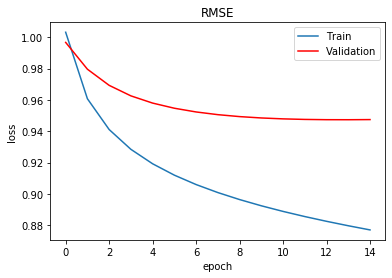

In [37]:
model_ml = SVD(params, total_users, total_items)
model_ml.fit(train_set, val_set, 1, plot=True)

In [38]:
model_ml.test(test_set)

RMSE on test set: 1.0174982541984474


### Basic model with biases

Epoch: 0   RMSE: 1.1495008939617049  Val_RMSE: 1.1535987249583823
Epoch: 1   RMSE: 1.123983528176987  Val_RMSE: 1.1499335330656473
Epoch: 2   RMSE: 1.1010361942231295  Val_RMSE: 1.1467527147003085
Epoch: 3   RMSE: 1.0798590903330503  Val_RMSE: 1.1439680177474785
Epoch: 4   RMSE: 1.0600455527094037  Val_RMSE: 1.1415177465489776
Epoch: 5   RMSE: 1.0413396740507923  Val_RMSE: 1.1393551559192492
Epoch: 6   RMSE: 1.0235612166347003  Val_RMSE: 1.1374431279997081
Epoch: 7   RMSE: 1.0065746590997557  Val_RMSE: 1.1357512867350512
Epoch: 8   RMSE: 0.9902736554050816  Val_RMSE: 1.1342542469025039
Epoch: 9   RMSE: 0.9745721901890202  Val_RMSE: 1.1329304641198386
Epoch: 10   RMSE: 0.9593991093085683  Val_RMSE: 1.131761434813199
Epoch: 11   RMSE: 0.9446945312895737  Val_RMSE: 1.1307311151952615
Epoch: 12   RMSE: 0.9304073854142172  Val_RMSE: 1.1298254852056457
Epoch: 13   RMSE: 0.9164936628347575  Val_RMSE: 1.1290322127245207
Epoch: 14   RMSE: 0.902915139017063  Val_RMSE: 1.1283403896141861
Epoch: 1

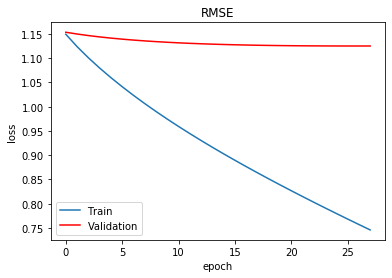

In [59]:
model = SVD(params, total_users, total_items)
model.fit(train_set, val_set, 1, plot=True)

In [60]:
model.test(test_set)

RMSE on test set: 1.1304159542385113


### More bias regularisation

In [ ]:
params['bu_reg'] = 0.1
params['bi_reg'] = 0.1
model2 = SVD(params, total_users, total_items)
model2.fit(train_set, val_set, 1, plot=True)

In [ ]:
model2.test(test_set)

### Model with impl_fb

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.1520435805818146  Val_RMSE: 1.1559070343225328
Epoch: 1   RMSE: 1.118616855222398  Val_RMSE: 1.1518711451230945
Epoch: 2   RMSE: 1.0898483492001139  Val_RMSE: 1.148486419016559
Epoch: 3   RMSE: 1.0640150075835142  Val_RMSE: 1.1455737675822
Epoch: 4   RMSE: 1.0403311604021583  Val_RMSE: 1.1430378909925578
Epoch: 5   RMSE: 1.0183283123105469  Val_RMSE: 1.1408160128914195
Epoch: 6   RMSE: 0.9976898914699311  Val_RMSE: 1.138861990874051
Epoch: 7   RMSE: 0.9781860998284434  Val_RMSE: 1.1371397854304175
Epoch: 8   RMSE: 0.9596421872184575  Val_RMSE: 1.1356202052503979
Epoch: 9   RMSE: 0.9419208458307021  Val_RMSE: 1.1342790375245964
Epoch: 10   RMSE: 0.924911554369342  Val_RMSE: 1.133095858450034
Epoch: 11   RMSE: 0.9085237165066768  Val_RMSE: 1.1320532204475136
Epoch: 12   RMSE: 0.8926820311275026  Val_RMSE: 1.13113606819962
Epoch: 13   RMSE: 0.877323251084325  Val_RMSE: 1.1303313035796003
Epoch: 14   RMSE: 0.862393844246952

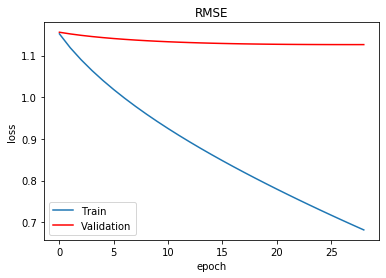

In [61]:
params['use_impl_fb'] = True
params['x_reg'] = 0.9
model3= SVD(params, total_users, total_items)
model3.fit(train_set, val_set, 1, plot=True)

In [62]:
model3.test(test_set)

RMSE on test set: 1.1319186156392735


### Model with impl_fb more regularisation

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.1518586537158881  Val_RMSE: 1.154406250019155
Epoch: 1   RMSE: 1.1209084076029667  Val_RMSE: 1.1501606308086796
Epoch: 2   RMSE: 1.095115071543519  Val_RMSE: 1.1467080887022383
Epoch: 3   RMSE: 1.0721119654029165  Val_RMSE: 1.1437681454524842
Epoch: 4   RMSE: 1.0510441487026068  Val_RMSE: 1.1412210064450212
Epoch: 5   RMSE: 1.0314451388192452  Val_RMSE: 1.1389954449310322
Epoch: 6   RMSE: 1.01301650563446  Val_RMSE: 1.1370418533824826
Epoch: 7   RMSE: 0.9955494716089035  Val_RMSE: 1.1353226608546172
Epoch: 8   RMSE: 0.9788893388320604  Val_RMSE: 1.1338079922799509
Epoch: 9   RMSE: 0.9629167878424081  Val_RMSE: 1.1324733440161379
Epoch: 10   RMSE: 0.9475370308115938  Val_RMSE: 1.131298184740693
Epoch: 11   RMSE: 0.9326730623676764  Val_RMSE: 1.1302650411540291
Epoch: 12   RMSE: 0.9182612322187924  Val_RMSE: 1.1293588640603736
Epoch: 13   RMSE: 0.9042482185773694  Val_RMSE: 1.1285665690538718
Epoch: 14   RMSE: 0.890588889

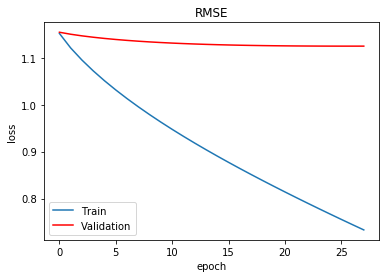

In [63]:
params['use_impl_fb'] = True
params['x_reg'] = 5
model4= SVD(params, total_users, total_items)
model4.fit(train_set, val_set, 1, plot=True)

In [64]:
model4.test(test_set)

RMSE on test set: 1.130798866373235


### Model with impl_fb MORE regularisation

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.1510587005505573  Val_RMSE: 1.1533714926640857
Epoch: 1   RMSE: 1.1219677785707753  Val_RMSE: 1.1493493147444984
Epoch: 2   RMSE: 1.0978541935484454  Val_RMSE: 1.146039131650629
Epoch: 3   RMSE: 1.07614706920191  Val_RMSE: 1.1432085321051515
Epoch: 4   RMSE: 1.0560814507473695  Val_RMSE: 1.1407498291250877
Epoch: 5   RMSE: 1.0372629424535453  Val_RMSE: 1.1385966555014306
Epoch: 6   RMSE: 1.0194457501474286  Val_RMSE: 1.1367025599109208
Epoch: 7   RMSE: 1.0024599735948951  Val_RMSE: 1.1350324745074793
Epoch: 8   RMSE: 0.9861801501073346  Val_RMSE: 1.13355857761243
Epoch: 9   RMSE: 0.9705092693458871  Val_RMSE: 1.132258041019648
Epoch: 10   RMSE: 0.9553697528953007  Val_RMSE: 1.1311116903700207
Epoch: 11   RMSE: 0.9406979714404722  Val_RMSE: 1.1301031474372063
Epoch: 12   RMSE: 0.9264407202329912  Val_RMSE: 1.1292182461397406
Epoch: 13   RMSE: 0.9125528514626579  Val_RMSE: 1.1284446147147462
Epoch: 14   RMSE: 0.8989956259

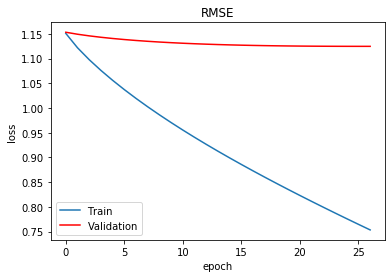

In [66]:
params['use_impl_fb'] = True
params['x_reg'] = 15
model5 = SVD(params, total_users, total_items)
model5.fit(train_set, val_set, 1, plot=True)

In [67]:
model5.test(test_set)

RMSE on test set: 1.1302504004018814


### Model with impl_fb MORE MORE regularisation

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.1500981240233035  Val_RMSE: 1.1528941568858229
Epoch: 1   RMSE: 1.1228870695300863  Val_RMSE: 1.1491002410304614
Epoch: 2   RMSE: 1.099793627257529  Val_RMSE: 1.1459243330100806
Epoch: 3   RMSE: 1.0786080294782452  Val_RMSE: 1.1431660855061145
Epoch: 4   RMSE: 1.0588056680564797  Val_RMSE: 1.1407449781392918
Epoch: 5   RMSE: 1.0401105120036782  Val_RMSE: 1.1386106565862213
Epoch: 6   RMSE: 1.0223388553431132  Val_RMSE: 1.1367253913123503
Epoch: 7   RMSE: 1.005354935049728  Val_RMSE: 1.1350588154520163
Epoch: 8   RMSE: 0.9890527572068873  Val_RMSE: 1.1335856672247713
Epoch: 9   RMSE: 0.9733467228242975  Val_RMSE: 1.1322845304529272
Epoch: 10   RMSE: 0.9581660652507542  Val_RMSE: 1.1311370139980006
Epoch: 11   RMSE: 0.9434512560192845  Val_RMSE: 1.1301271698943918
Epoch: 12   RMSE: 0.929151551150687  Val_RMSE: 1.1292410600453446
Epoch: 13   RMSE: 0.9152232499778387  Val_RMSE: 1.1284664231825863
Epoch: 14   RMSE: 0.9016284

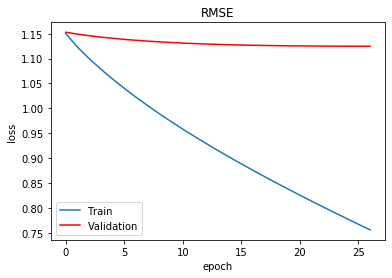

In [69]:
params['use_impl_fb'] = True
params['x_reg'] = 50
model6 = SVD(params, total_users, total_items)
model6.fit(train_set, val_set, 1, plot=True)

In [70]:
model6.test(test_set)

RMSE on test set: 1.1315224089239866


## AUC

In [88]:
def AUC(train,test,model):
    U = model.model['p']
    I = model.model['q']
    mu = model.mu
    b_i = model.model['bi']
    b_u = model.model['bu']
    
    ans=0
    cc=0
    for u in train['new_user_id']:
        i=test[test['new_user_id']==u]['new_item_id'].iloc[0]
        T=mu + b_u[u] + np.dot(U[u,:],I.T)
        cc+=1
        M=set()      
        for item in train[train['new_user_id']==u]['new_item_id']:
            M.add(item)
        M.add(i)   
            
        count=0
        tmpans=0
        #for j in xrange(itemnum):
        for j in rand.sample(range(total_items),100): #sample
            if j in M: continue
            if T[i] + b_i[i] > T[j] + b_i[j]: 
                tmpans+=1
            count+=1
        tmpans/=float(count)
        ans+=tmpans
    ans/=float(cc)
    return ans

In [89]:
def AUC_ranked(train,test,model):
    U = model.model['p']
    I = model.model['q']
    mu = model.mu
    b_i = model.model['bi']
    b_u = model.model['bu']
    
    ans=0
    cc=0
    
    for u in train['new_user_id']:
        i=test[test['new_user_id']==u]['new_item_id'].iloc[0]
        T=mu + b_u[u] + np.dot(U[u,:],I.T)
        cc+=1
        M=[]      
        for item in train[train['new_user_id']==u]['new_item_id']:
            M.append(item)
        M.append(i)   
        M = sorted(M, reverse=True)
        i_index = M.index(i)
        
        count=0
        tmpans=0
        #for j in xrange(itemnum):
        for j in M[i_index:]: #sample
#             if j in M: continue
            if T[i] + b_i[i] > T[j] + b_i[j]: 
                tmpans+=1
            count+=1
        tmpans/=float(count)
        ans+=tmpans
    ans/=float(cc)
    return ans

In [90]:
print('ready')

ready


In [ ]:
auc1 = AUC1(train_set, test_set, model)

In [ ]:
auc1

In [40]:
auc1_ml = AUC1(train_set, test_set, model_ml)

In [73]:
auc1_ml

0.43219128051266475

In [91]:
auc_ranked = AUC_ranked(train_set, test_set, model_ml)

In [92]:
auc_ranked

0.17462422961268434

## Store Results

In [ ]:
log_path = 'Results/'
res_name = 'res_#ratings_ui_above_3'

In [ ]:
model.store_results(log_path, res_name, user_thres, item_thres)

## Delete last results

In [ ]:
# pd.read_pickle(log_path + res_name)[1:].to_pickle(log_path + res_name)

## Cross Validation all algs

In [ ]:
from sklearn.model_selection import KFold
def cv(data, params, n_splits, res_name, model_res_name):
    kf = KFold(n_splits = n_splits, shuffle = True)
    full_data = data
    scores = []

    for i in range(n_splits):
        result = next(kf.split(full_data), None)
        train_set = full_data.iloc[result[0]]
        test_set = full_data.iloc[result[1]]
        model = SVD(params, total_users, total_items)
        model.fit(train_set, verbose = 1000, plot = False)
        
        model.test(test_set)
        model.store_results('', model_res_name, user_thres, item_thres)  

    df_cv_results = pd.read_pickle(model_res_name)[-5:]
    params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'use_color', 'use_weight_ver', 'ver_weight' 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
    avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
    final_dict = {**avg_rmse_dict, **params_dict}

    if not os.path.exists(res_name):
        cv_res = pd.DataFrame(columns=final_dict.keys())
        print('new results created')

    else:
        cv_res = pd.read_pickle(res_name)
        print('results added')

    cv_res = cv_res.append(final_dict, ignore_index=True)
    pd.to_pickle(cv_res, res_name)

### Bias Only

In [ ]:
params

In [ ]:
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_only'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Weighted Verification and Bias

In [ ]:
params

In [ ]:
params['use_weight_ver'] = True
params['ver_weight'] = 0.7
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Impl_fb with Bias

In [ ]:
params

In [ ]:
params['use_weight_ver'] = False
params['use_impl_fb'] = True
params['x_reg'] = 0.01
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Color attribute with Bias

In [ ]:
params

In [ ]:
params['use_impl_fb'] = False
params['use_color'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Impl_fb with verification weights and Bias

In [ ]:
params

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = False
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_ver_weight_impl_fb'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Color, impl_fb, weight_ver and bias

In [ ]:
params['use_impl_fb'] = True
params['use_color'] = True
params['use_weight_ver'] = True
log_path = 'Results/'
res_name = log_path + 'cv_#ratings_ui_above_3_all_algs'
cv_res_name = log_path + 'cv_#ratings_ui_above_3_bias_impl_fb_weight_color'
n_splits = 5

cv(df_new_ids, params, n_splits, res_name, cv_res_name)

### Results CV all algs

In [ ]:
df_cv_results = pd.read_pickle(res_name).sort_values('avg_rmse_test')
df_cv_results

# Read and View Results

## All models

In [ ]:
pd.read_pickle(log_path +'all_results_movie_lens')

### Old but gold

In [ ]:
pd.read_pickle('Results/df_comparison_impl_fb')

In [ ]:
df_results = pd.read_pickle('Results/' + 'df_results_svd')
df_results.sort_values('RMSE_test')

Note the RMSE in the first results should be higher (+1.1) due to a mistake in the calculation

In [ ]:
x = ['with Bias and Reg', 'with Bias', 'Plain']
y = [1.313160, 1.314319, 2.860927]

fig, ax = plt.subplots()
ind = np.arange(len(y))
width = 0.8
ax.bar(ind, y, width, color=['darkblue'])
ax.set_xticks(ind+width/500)
ax.set_xticklabels(x, minor=False)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
for i, v in enumerate(y):
    ax.text(i -0.2, v + 0.02, str(v), fontweight='bold')
plt.show()

## Best model train RMSE

### Best from Comparison

In [ ]:
best = df_results_b.iloc[6]
model.plot_rmse(best['train_rmse'])

### Best of All Models

In [ ]:
best = df_results_all
model.plot_rmse(best['train_rmse'])

# Appendix

## Data Split (Pandas)

In [ ]:
# from scipy.linalg import sqrtm

# X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True, random_state=1234)
# X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

# def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
#     """
#         :param data:      Array-like, 2D, nx3
#         :param formatizer:pass the formatizer
#         :return:          utility matrix (n x m), n=users, m=items
#     """
        
#     itemField = formatizer['item']
#     userField = formatizer['user']
#     valueField = formatizer['value']
    
#     userList = data.iloc[:,userField].tolist()
#     itemList = data.iloc[:,itemField].tolist()
#     valueList = data.iloc[:,valueField].tolist()
    
#     users = list(set(data.iloc[:,userField]))
#     items = list(set(data.iloc[:,itemField]))
    
#     users_index = {users[i]: i for i in range(len(users))}
#     pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    
#     for i in range(0,len(data)):
#         item = itemList[i]
#         user = userList[i]
#         value = valueList[i]
        
#     pd_dict[item][users_index[user]] = value
#     X = pd.DataFrame(pd_dict)
#     X.index = users
        
#     itemcols = list(X.columns)
#     items_index = {itemcols[i]: i for i in range(len(itemcols))}
#     # users_index gives us a mapping of user_id to index of user
#     # items_index provides the same for items
#     return X, users_index, items_index

# X, users_index, items_index = create_utility_matrix(X_train)

hide_toggle()

## Create user item matrix

In [ ]:
# n_users = df.user.unique().shape[0]
# n_items = df.item.unique().shape[0]

# ratings_train = np.zeros((n_users, n_items))
# for row in X_train.itertuples():
#         ratings_train[row[5], row[4]] = row[3]

# pd.DataFrame(ratings_train).head()
# # sparse.csr_matrix((X_train['rating']),shape(n_users, n_items))
hide_toggle()

## Different SGD coding

In [ ]:
# user_item_combos = 0
# for epoch in range(n_epochs):
#     for u in range(ratings_train.shape[0]): #users
#         for i in range(ratings_train.shape[1]): #items
#             r_ui = ratings_train[u,i]
            
#             if  r_ui != 0:
#                 user_item_combos += 1
#                 error = r_ui - np.dot(p[u], q[i])
                
#                 p[u] += alpha *(error * q[i])
#                 q[i] += alpha * (error * p[u])
                
#                 total_error += np.square(error)
# #         print(total_error)
#     rmse = math.sqrt(total_error)
#     print('epoch: ', epoch)#, '  rmse: ', rmse)
#     print(user_item_combos, X_train['rating'].shape[0])
hide_toggle()

## With regularization

In [ ]:
# b_user[u] += alpha_b * (error - bu_reg * b_user[u])
# b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            
# p[u] += alpha * (error * q[i] - pu_reg * p[u])
# q[i] += alpha * (error * p[u] - qi_reg * q[i])
hide_toggle()

## Colors binary split

In [ ]:
# plt.rcParams['figure.figsize'] = [8,6]
# pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]/len(df)).sum()
# non_pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/len(df)).sum()

# bars = plt.bar(['pop_col', 'non_pop_col'], [pop_col, non_pop_col])
# plt.text(bars[0].get_x() + 0.13, pop_col + -0.05, pop_col, color="white", fontweight = 'bold')
# plt.text(bars[1].get_x() + 0.13, non_pop_col + -0.05, non_pop_col, color="white", fontweight = 'bold')
# plt.title('Binary split between 35 most populair colors and non populair colors')
# plt.show()

In [ ]:
# pop_colors = df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35] 

# def pop_color(x):
#     x = x['Color:']
#     if x in pop_colors:
#         return 1
#     elif x not in pop_colors:
#         return 0
#     else:
#         return False

# temp_df = pd.DataFrame()
# temp_df['bin_pop_col'] = df.apply(pop_color, axis=1, result_type='expand')
# df = df.merge(temp_df, left_index=True, right_index=True)